In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!git clone https://github.com/Anjaas85/authentic_vs_AI_generated_photos


Cloning into 'authentic_vs_AI_generated_photos'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 48 (delta 4), reused 11 (delta 0), pack-reused 30 (from 1)
Receiving objects: 100% (48/48), 161.00 MiB | 12.61 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
%cd authentic_vs_AI_generated_photos

/content/authentic_vs_AI_generated_photos


In [3]:
!ls


checkpoints  data  logs  models  two_class_classification.ipynb  utils


In [4]:
!git branch epochs20

In [5]:
!git checkout epochs20

Switched to branch 'epochs20'


In [6]:
# Downloading and Distributing the dataset
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import os
from PIL import Image

# Step 1: Define paths
data_root = "./data"
train_dir = os.path.join(data_root, "train")
val_dir = os.path.join(data_root, "val")
class_dirs = ["class_0", "class_1"]

# Step 2: Create folder structure
for directory in [train_dir, val_dir]:
    for class_dir in class_dirs:
        os.makedirs(os.path.join(directory, class_dir), exist_ok=True)

# Step 3: Download CIFAR10 dataset
cifar10 = CIFAR10(root="./", download=True)
data, labels = cifar10.data, cifar10.targets

# Step 4: Simulate CIFAKE10 (first 5 classes as "authentic", next 5 as "AI-generated")
labels = [0 if label < 5 else 1 for label in labels]

# Step 5: Split data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

# Helper function to save images
def save_images(images, labels, save_dir):
    for idx, (image, label) in enumerate(zip(images, labels)):
        class_folder = os.path.join(save_dir, f"class_{label}")
        img = Image.fromarray(image)
        img.save(os.path.join(class_folder, f"{idx}.png"))

# Step 6: Save images to train and val folders
save_images(train_data, train_labels, train_dir)
save_images(val_data, val_labels, val_dir)

print("CIFAKE10 dataset distributed into train and validation folders.")




from models.densenet_model import create_densenet
from utils.data_loader import create_dataloaders, create_test_loader
from utils.evaluation import evaluate_model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import json
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
import numpy as np


# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths and parameters
data_dir = 'data'

# Load train, validation, and test data
dataloaders = create_dataloaders(data_dir, batch_size=32)
test_loader = create_test_loader( batch_size=32)

# Load model
model = create_densenet(num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Training function with extended metrics saving
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    metrics_file_path = os.path.join('metrics', 'metrics_by_epoch.txt')
    os.makedirs('metrics', exist_ok=True)

    # Initialize storage for metrics
    metrics_data = {
        "precision_recall": [],
        "f1_scores": [],
        "val_probs": [],
        "val_labels": [],
        "confusion_matrices": [],
        "epoch_metrics": []
    }

    with open(metrics_file_path, 'w') as f:
        f.write(f'Epoch\tPhase\tLoss\tAccuracy\n')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                all_labels = []
                all_probs = []

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        probs = torch.softmax(outputs, dim=1)[:, 1]
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_labels.extend(labels.cpu().numpy().tolist())
                    all_probs.extend(probs.detach().cpu().numpy().tolist())

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                # Print and save metrics
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                f.write(f'{epoch+1}\t{phase}\t{epoch_loss:.4f}\t{epoch_acc:.4f}\n')

                # Save metrics for validation phase
                if phase == 'val':
                    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
                    f1 = f1_score(all_labels, np.round(all_probs))
                    confusion_mat = confusion_matrix(all_labels, np.round(all_probs))

                    metrics_data["precision_recall"].append({
                        "precision": precision.tolist(),
                        "recall": recall.tolist(),
                        "thresholds": thresholds.tolist(),
                    })
                    metrics_data["f1_scores"].append(float(f1))
                    metrics_data["val_probs"].append(all_probs)
                    metrics_data["val_labels"].append(all_labels)
                    metrics_data["confusion_matrices"].append(confusion_mat.tolist())

                    metrics_data["epoch_metrics"].append({
                        "epoch": epoch+1,
                        "loss": float(epoch_loss),
                        "accuracy": float(epoch_acc)
                    })

    # Save metrics data as JSON
    with open(os.path.join('metrics', 'metrics_data.json'), 'w') as json_file:
        json.dump(metrics_data, json_file, indent=4)

    print(f"Metrics saved in {metrics_file_path} and metrics_data.json")
    return model


# Train the model
trained_model = train_model(model, criterion, optimizer, dataloaders, num_epochs=20)



# Save the model
torch.save(trained_model.state_dict(), 'checkpoints/densenet_ai_vs_authentic.pth')
print("Model trained and saved!")

# Evaluate the model
print("Evaluating on validation set:")
evaluate_model(trained_model, dataloaders['val'], device,"validation")

print("Evaluating on test set:")
evaluate_model(trained_model, test_loader, device, "test")




100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./cifar-10-python.tar.gz to ./
CIFAKE10 dataset distributed into train and validation folders.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 192MB/s]


Epoch 1/20
----------
train Loss: 0.6551 Acc: 0.6136
val Loss: 0.6387 Acc: 0.6489
Epoch 2/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6002 Acc: 0.6901
val Loss: 0.5825 Acc: 0.7093
Epoch 3/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5647 Acc: 0.7306
val Loss: 0.5520 Acc: 0.7444
Epoch 4/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5379 Acc: 0.7586
val Loss: 0.5328 Acc: 0.7673
Epoch 5/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5225 Acc: 0.7751
val Loss: 0.5060 Acc: 0.7924
Epoch 6/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5086 Acc: 0.7915
val Loss: 0.5075 Acc: 0.7864
Epoch 7/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4985 Acc: 0.8034
val Loss: 0.4822 Acc: 0.8183
Epoch 8/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4872 Acc: 0.8143
val Loss: 0.5047 Acc: 0.7975
Epoch 9/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4808 Acc: 0.8210
val Loss: 0.4810 Acc: 0.8194
Epoch 10/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4766 Acc: 0.8279
val Loss: 0.4694 Acc: 0.8348
Epoch 11/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4664 Acc: 0.8392
val Loss: 0.4640 Acc: 0.8386
Epoch 12/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4610 Acc: 0.8430
val Loss: 0.4627 Acc: 0.8407
Epoch 13/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4547 Acc: 0.8498
val Loss: 0.4579 Acc: 0.8472
Epoch 14/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4535 Acc: 0.8525
val Loss: 0.4569 Acc: 0.8458
Epoch 15/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4469 Acc: 0.8592
val Loss: 0.4446 Acc: 0.8611
Epoch 16/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4413 Acc: 0.8655
val Loss: 0.4429 Acc: 0.8633
Epoch 17/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4424 Acc: 0.8657
val Loss: 0.4455 Acc: 0.8598
Epoch 18/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4360 Acc: 0.8711
val Loss: 0.4443 Acc: 0.8604
Epoch 19/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4341 Acc: 0.8727
val Loss: 0.4371 Acc: 0.8673
Epoch 20/20
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.4298 Acc: 0.8764
val Loss: 0.4388 Acc: 0.8688
Metrics saved in metrics/metrics_by_epoch.txt and metrics_data.json
Model trained and saved!
Evaluating on validation set:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5000
           1       0.87      0.86      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
[[4378  622]
 [ 690 4310]]
Evaluating on test set:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.86      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:
[[4362  638]
 [ 677 4323]]


In [7]:
!git config --global user.email "anja.stanic2001@gmail.com"
!git config --global user.name "Anja Stanic"

In [ ]:
!git commit -m "First results for initial training on test and val"

In [ ]:
!git reset --soft HEAD~1


In [ ]:
!git reset

In [ ]:
!git log

In [15]:
!git add training20ep.ipynb

In [11]:
!git add checkpoints/densenet_ai_vs_authentic.pth

In [12]:
!git add utils/data_loader.py
!git add utils/evaluation.py
!git add models/densenet_model.py

In [13]:
!git add metrics/metrics_by_epoch.txt
!git add metrics/metrics_data.json
!git add metrics/metrics.txt

In [16]:
!git status

On branch epochs20
Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   checkpoints/densenet_ai_vs_authentic.pth
	new file:   metrics/metrics.txt
	new file:   metrics/metrics_by_epoch.txt
	new file:   metrics/metrics_data.json
	modified:   models/densenet_model.py
	new file:   training20ep.ipynb
	modified:   utils/data_loader.py
	modified:   utils/evaluation.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	cifar-10-batches-py/
	cifar-10-python.tar.gz
	data/train/class_0/
	data/train/class_1/
	data/val/class_0/
	data/val/class_1/
	models/__pycache__/
	utils/__pycache__/



In [17]:
!git commit -m "Training 20 epochs"

[epochs20 fb32edd] Training 20 epochs
 8 files changed, 701141 insertions(+), 13 deletions(-)
 create mode 100644 metrics/metrics.txt
 create mode 100644 metrics/metrics_by_epoch.txt
 create mode 100644 metrics/metrics_data.json
 create mode 100644 training20ep.ipynb


In [19]:
!ssh-keygen -t rsa -b 4096 -C "anja.stanic2001@gmail.com" -f ~/.ssh/id_rsa -N ""


Generating public/private rsa key pair.
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:RHIlV5stCugiSXI2co0F0U+GbOFAVVdf/il+5AcRwM0 anja.stanic2001@gmail.com
The key's randomart image is:
+---[RSA 4096]----+
| .=*++o =o+oo+o  |
|   *= o* o ..*E. |
|o B.o+. o   = +  |
| B o ... . . . o.|
|  o . . S .  ..o.|
|   . .      . +. |
|             . o.|
|              . .|
|                 |
+----[SHA256]-----+


In [20]:
!cat ~/.ssh/id_rsa.pub


ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDWi2mNpUmXHtXSoQybFr/WjDHyr9RMDoLcDfYseb4oojN7AojaTlEcjPeuHpQa5jDtgd7YNrH+LEmWoPa1EYvV0p5F0RkrEBuq6x6BzvuR4vR/EbQYArat5iOMeW/cUlSvLspzlyHMi/Tpy3z1eZkX7x2TEvzgTzIXq6kXRxn0mNvsGvRhaLOUT+M2JxMDE2pCgd0pXuMFNNeeqqrPoDHsnX63FWF6ZBCg5Fd3GCuJ9MORpveJ6aQ1dMdKDrUS52X89JBwNw9UJh5AXzglP1TXtwXYEiJgH5eHXy0n2IpZu8pDy6sA1MWjhFIJcAo4EVrUhxzRgE5RZA09K+VUmwV92J9XEjwvCAmAGRcE71Lw6vr6zwpjP4YylbEUZu6zmVVx61w55K8GUQulI0xB7D7wMfFv7ccEXNObpO5wNmCQsTZtqFl5Lj6SCLvdkDim4Y6gFHesEm2A5Cp9FI9hmp2t/gQVR0MxuqIuCfmB3/6vO5uodqSXYNlqbpIDMfXvblHijlRlK+OStVZIZj0NllIPVB/qCEQp6mJYVJxGUcpYRUo1iA9jltEGFTP0yfxKPX3d5zkpzwWUmxNe1I+Q6tejdzX3U9yXvsxo7OGRmLyjB3raLIex4f3ksx5JAqCqouCDp+++o3O+xrjoBXLs2PIZnibezBpz7lEi3q7NXmymbw== anja.stanic2001@gmail.com


In [21]:
!echo -e "Host github.com\n\tStrictHostKeyChecking no\n" >> ~/.ssh/config


In [28]:
!ssh -T git@github.com


Hi Anjaas85! You've successfully authenticated, but GitHub does not provide shell access.


In [32]:
!git push origin epochs20

Enumerating objects: 22, done.
Counting objects: 100% (22/22), done.
Delta compression using up to 2 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (14/14), 29.07 MiB | 2.21 MiB/s, done.
Total 14 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: 
remote: Create a pull request for 'epochs20' on GitHub by visiting:
remote:      https://github.com/Anjaas85/authentic_vs_AI_generated_photos/pull/new/epochs20
remote: 
To github.com:Anjaas85/authentic_vs_AI_generated_photos.git
 * [new branch]      epochs20 -> epochs20


In [31]:
!git remote -v


origin	git@github.com:Anjaas85/authentic_vs_AI_generated_photos.git (fetch)
origin	git@github.com:Anjaas85/authentic_vs_AI_generated_photos.git (push)


In [30]:
!git remote set-url origin git@github.com:Anjaas85/authentic_vs_AI_generated_photos.git


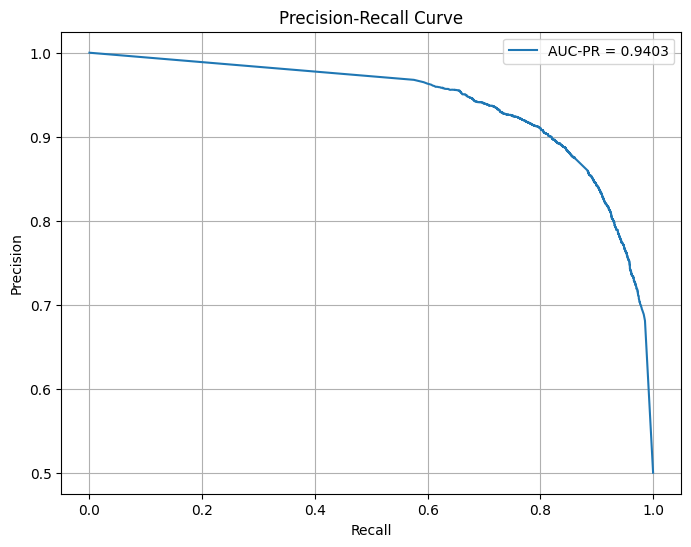

In [33]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Load metrics data
with open('metrics/metrics_data.json', 'r') as f:
    metrics_data = json.load(f)

# Extract Precision-Recall data
precision_recall = metrics_data["precision_recall"][-1]  # Use last epoch
precision = precision_recall["precision"]
recall = precision_recall["recall"]

# Calculate AUC-PR
auc_pr = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


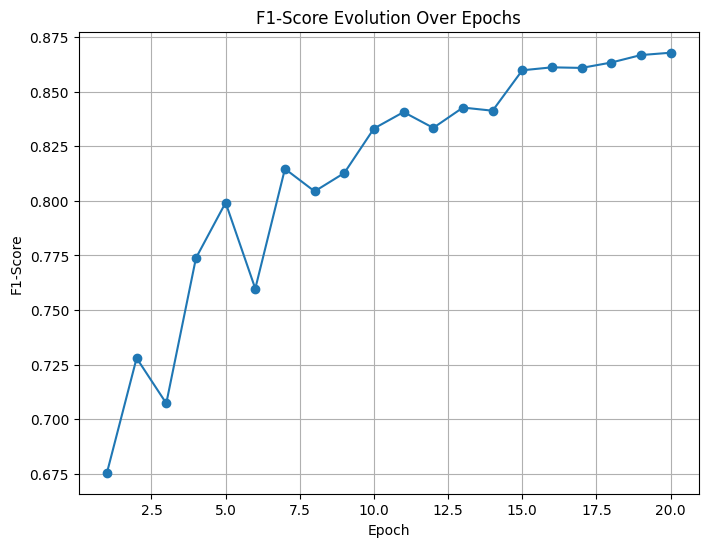

In [34]:
# Extract F1-scores
f1_scores = metrics_data["f1_scores"]

# Plot F1-scores over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Evolution Over Epochs')
plt.grid(True)
plt.show()


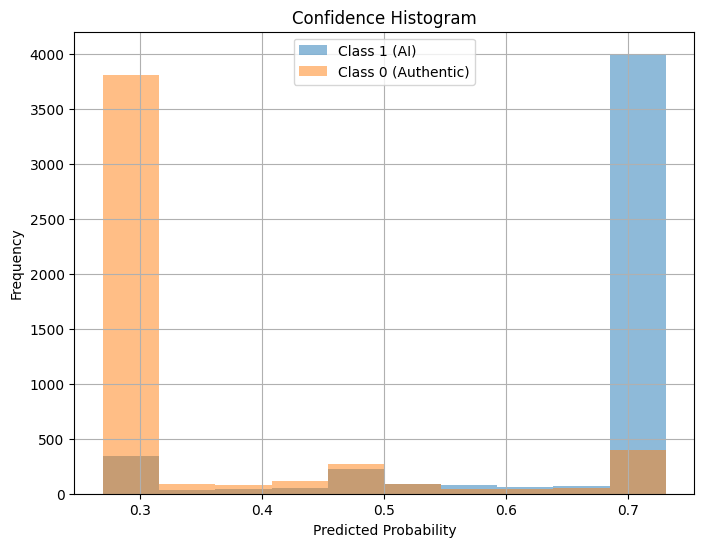

In [35]:
import numpy as np

# Extract validation probabilities from the last epoch
val_probs = np.array(metrics_data["val_probs"][-1])
val_labels = np.array(metrics_data["val_labels"][-1])

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(val_probs[val_labels == 1], bins=10, alpha=0.5, label='Class 1 (AI)')
plt.hist(val_probs[val_labels == 0], bins=10, alpha=0.5, label='Class 0 (Authentic)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Confidence Histogram')
plt.legend()
plt.grid(True)
plt.show()


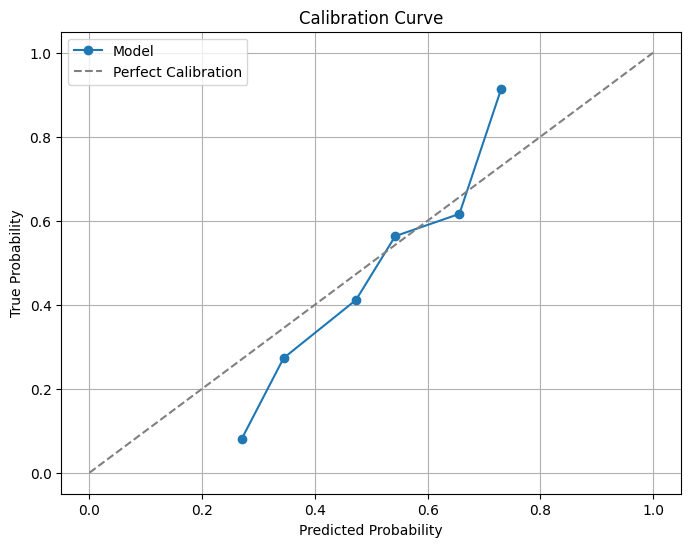

In [36]:
from sklearn.calibration import calibration_curve

# Extract validation labels and probabilities
probs = np.array(metrics_data["val_probs"][-1])
labels = np.array(metrics_data["val_labels"][-1])

# Generate calibration curve
prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


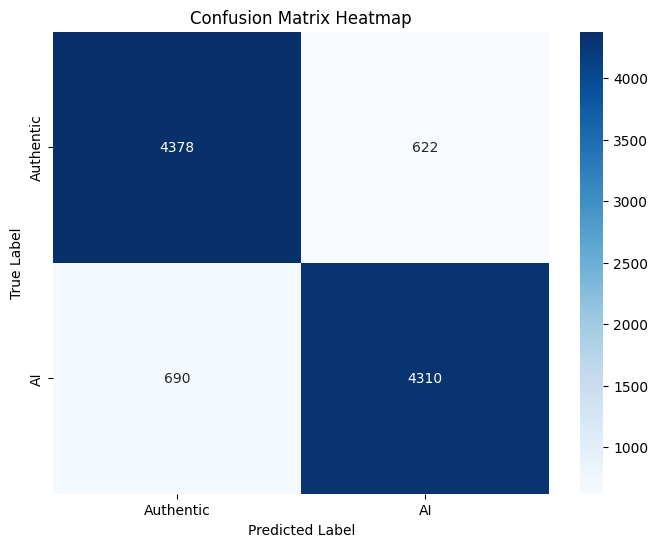

In [37]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Extract the last confusion matrix
conf_matrix = np.array(metrics_data["confusion_matrices"][-1])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Authentic", "AI"], yticklabels=["Authentic", "AI"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


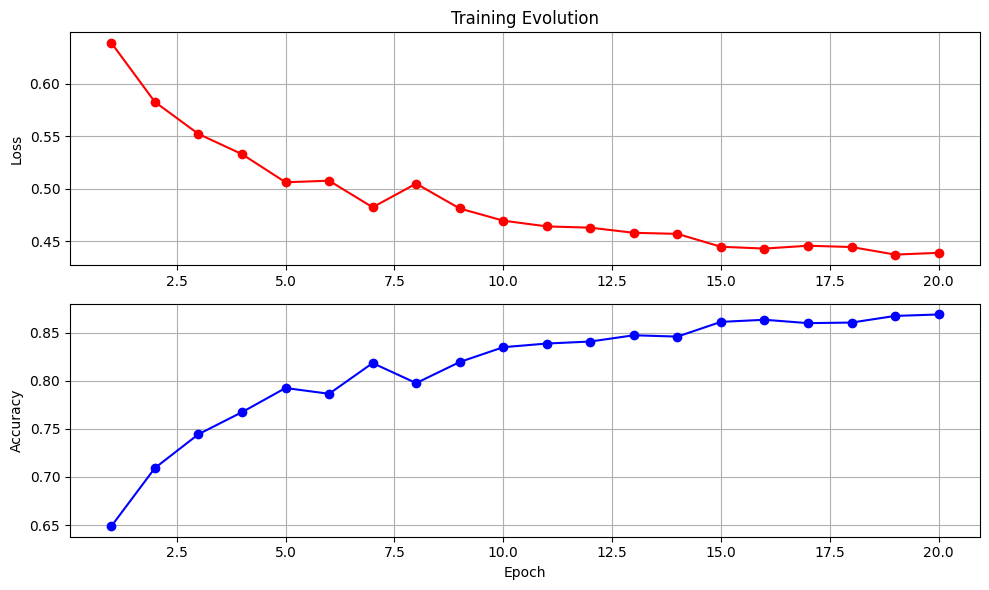

In [38]:
# Extract epoch metrics
epoch_metrics = metrics_data["epoch_metrics"]
epochs = [m["epoch"] for m in epoch_metrics]
loss = [m["loss"] for m in epoch_metrics]
accuracy = [m["accuracy"] for m in epoch_metrics]

# Plot Loss and Accuracy
plt.figure(figsize=(10, 6))

# Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, marker='o', color='r')
plt.title('Training Evolution')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
